# Flower Image Classifcation (Keras)

**Author**: Franko Ndou

# Overview

Welcome to the realm of BlossomTech, where innovation and nature converge. In this project, we are embarking on an exciting journey into the field of flower image classification with the power of Keras. Before we dive into the technical intricacies, it's essential to provide context. Imagine a world where the beauty and diversity of flowers have captivated humanity for centuries. Flowers hold a unique place in our lives, from cultural symbolism to scientific research and commercial applications. However, the process of accurately identifying and understanding different flower species has traditionally relied on manual expertise, often a time-consuming and challenging endeavor. In this project, we aim to revolutionize this age-old practice by automating flower identification. To fully appreciate the significance of our mission, let's begin by exploring the specific business challenges that fuel our journey.

# Business Problem

I was employed as a Data Scientist at "BlossomTech," a cutting-edge technology company specializing in AI and computer vision solutions. BlossomTech has recognized the growing demand for automated flower identification in various industries, including agriculture, horticulture, and e-commerce. My role as a Data Scientist is to develop a flower image classification model to address the following business challenges:

* Efficient Flower Identification: BlossomTech aims to provide a fast and accurate solution for flower identification, as traditional methods can be time-consuming and error-prone. Developing an image classification model will enhance efficiency and productivity in various sectors.
<br>

* Botanical Research Support: Botanists and researchers often need to identify and categorize different flower species for their studies. BlossomTech's model can support botanical research by providing a reliable tool for flower recognition.
<br>

* E-commerce Enhancement: BlossomShop, an e-commerce platform owned by BlossomTech, wants to integrate flower recognition technology into its mobile app. This will enable users to quickly identify and purchase flowers they encounter in their daily lives, enhancing the shopping experience.
<br>

* Gardening Assistance: BlossomGarden, a subsidiary of BlossomTech, offers gardening apps to help gardening enthusiasts. The image classification model can be integrated into these apps, allowing users to identify and learn about the flowers they encounter in their gardens.
<br>

* Educational Resources: BlossomTech aims to collaborate with educational institutions to provide a valuable educational tool for students studying botany and horticulture. The model can help students learn about different flower species and their unique characteristics.

Addressing these business challenges will not only establish BlossomTech as a leader in the field of flower recognition technology but also create new opportunities for growth and innovation in various industries. As the Data Scientist leading this project, your goal is to develop a highly accurate and efficient flower image classification model using Keras, providing a comprehensive solution to these business needs.

# Dataset

For this project, we will use the "Flower Classification" dataset, which is available on Kaggle. The dataset consists of a diverse collection of flower images belonging to various species. Each image is labeled with the corresponding flower species, making it suitable for supervised machine learning. The dataset contains a sufficient number of images for training, validation, and testing purposes.

You can access the dataset on Kaggle using the following link: [Flower Classification Dataset](https://www.kaggle.com/datasets/marquis03/flower-classification)

This dataset will serve as the foundation for training and evaluating our Keras-based flower image classification model.


# Pre-Processing

## Importing Libraries

In [45]:
# Common libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random
import csv
import h5py
import seaborn as sns

# CNN libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras_tuner import HyperParameters

# Misc
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [47]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", gpus)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Importing Data

We do not need to nor want to run this code twice or multiple times so the code below will be put in raw format

Ive decided to personally augment the train and val folders myself. Intially there were 7 pictures within each subfolder in val and about 13,000 images in train with a mixture of "generally" balanced data. However I took it upon myself to simply randomly select 200 images from each folder and move it over to the val folder and use that as my test

Running this code again would move an aditional 200 images which is NOT what we want

However the only problem is that we now have mismatched CSV files so this code recreated our val and train csv to account for the new images and loss of images

This will update the CSV files with the proper labeling and length

In [5]:
# Define the path to the directory containing class subfolders
train_dir = '../data/train'
test_dir = '../data/val'

# Create data generators for training and test
# Train data set has been augmented
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
 
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle = False
)

# Access the classes
train_labels = train_data.classes
test_labels = test_data.classes

train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

Found 10842 images belonging to 14 classes.
Found 2898 images belonging to 14 classes.


Now that we have Imported all the data required. We can perform an EDA and begin training our model shortly Afterwards

## EDA

In [6]:
# Define the path to your train folder
train_dir = '../data/train'

# List all subfolders within the train directory
subfolders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

# Iterate through subfolders and count JPEG files
for folder in subfolders:
    folder_name = os.path.basename(folder)
    jpg_files = glob.glob(os.path.join(folder, '*.jpg'))
    num_jpg_files = len(jpg_files)
    print(f"Folder '{folder_name}' contains {num_jpg_files} JPEG files.")


Folder 'astilbe' contains 526 JPEG files.
Folder 'bellflower' contains 672 JPEG files.
Folder 'black_eyed_susan' contains 786 JPEG files.
Folder 'calendula' contains 811 JPEG files.
Folder 'california_poppy' contains 821 JPEG files.
Folder 'carnation' contains 724 JPEG files.
Folder 'common_daisy' contains 778 JPEG files.
Folder 'coreopsis' contains 835 JPEG files.
Folder 'dandelion' contains 838 JPEG files.
Folder 'iris' contains 841 JPEG files.
Folder 'rose' contains 786 JPEG files.
Folder 'sunflower' contains 813 JPEG files.
Folder 'tulip' contains 834 JPEG files.
Folder 'water_lily' contains 777 JPEG files.


The amount of images within each subfolder inside our train dataset

### Visualization of data 

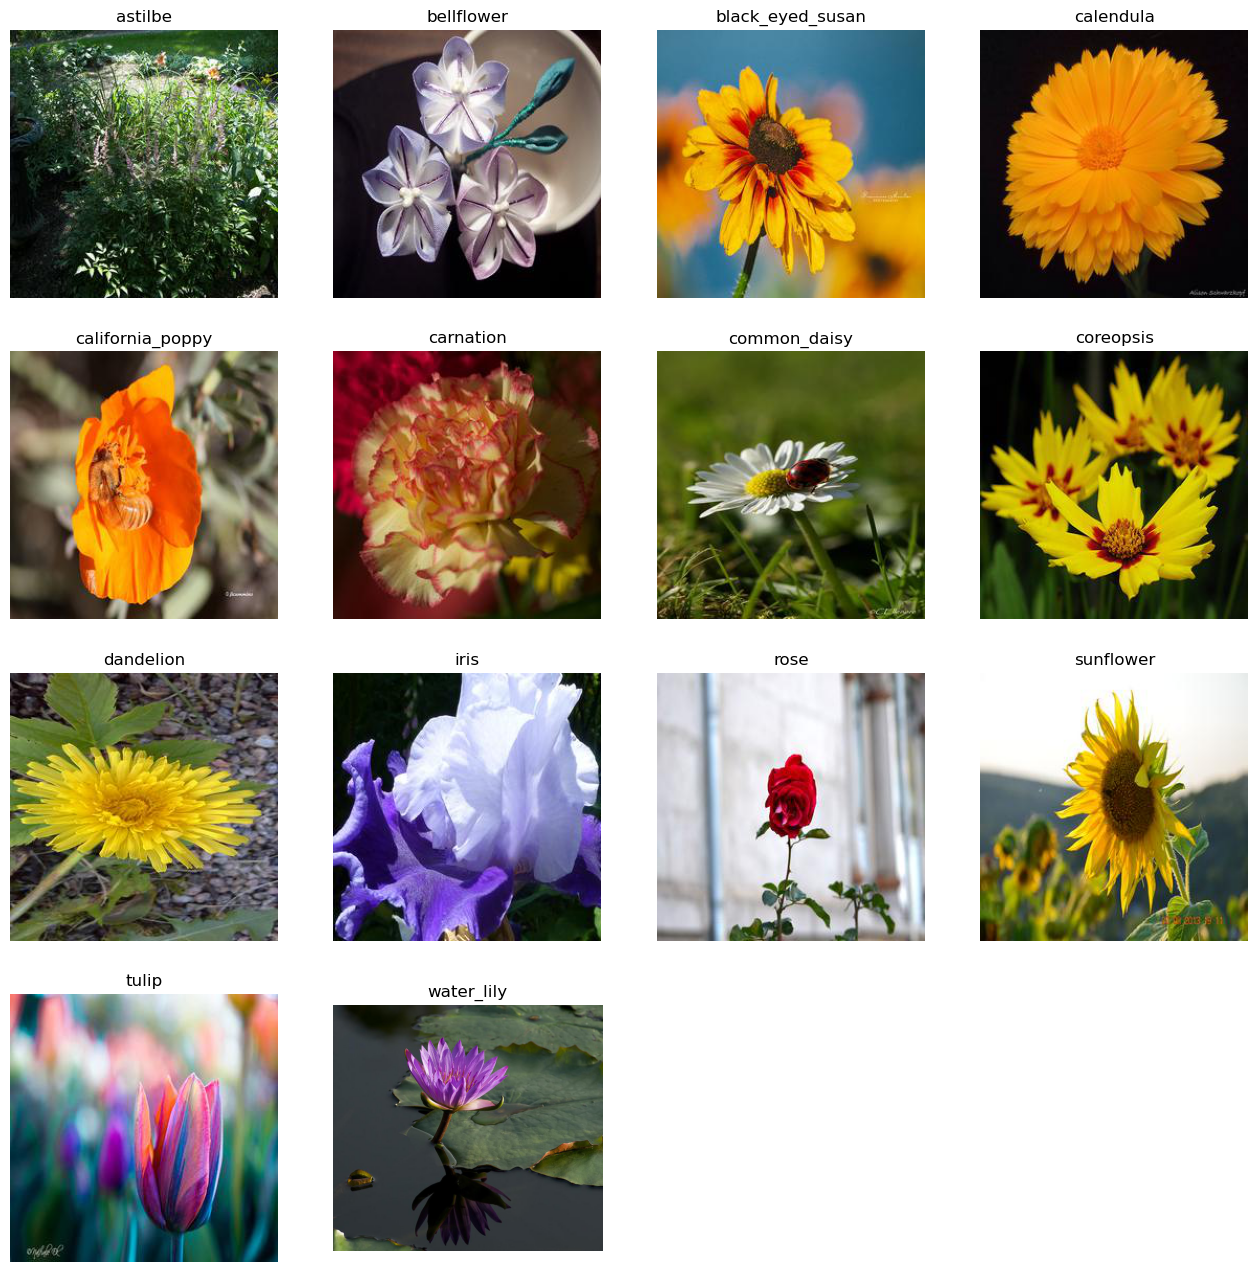

Class: astilbe
Train Data: 526 images
Test Data: 207 images

Class: bellflower
Train Data: 672 images
Test Data: 207 images

Class: black_eyed_susan
Train Data: 786 images
Test Data: 207 images

Class: calendula
Train Data: 811 images
Test Data: 207 images

Class: california_poppy
Train Data: 821 images
Test Data: 207 images

Class: carnation
Train Data: 724 images
Test Data: 207 images

Class: common_daisy
Train Data: 778 images
Test Data: 207 images

Class: coreopsis
Train Data: 835 images
Test Data: 207 images

Class: dandelion
Train Data: 838 images
Test Data: 207 images

Class: iris
Train Data: 841 images
Test Data: 207 images

Class: rose
Train Data: 786 images
Test Data: 207 images

Class: sunflower
Train Data: 813 images
Test Data: 207 images

Class: tulip
Train Data: 834 images
Test Data: 207 images

Class: water_lily
Train Data: 777 images
Test Data: 207 images



In [7]:
# Define the test data directory
test_data_dir = r'../data/val/'

# Define the classes (subfolders)
class_names = list(test_data.class_indices.keys())

# Function to get a sample image from a specific class
def get_sample_image(class_name):
    class_path = os.path.join(test_data_dir, class_name)
    for file in os.listdir(class_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(class_path, file)
            return plt.imread(image_path)

# Create a figure to display images
plt.figure(figsize=(16, 16))

# Iterate through the class names and display one image from each class
for i, class_name in enumerate(class_names):
    sample_image = get_sample_image(class_name)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_image)
    plt.title(class_name)
    plt.axis('off')

plt.show()

# Define the paths to the train and test data directories
train_data_dir = r'../data/train/'
test_data_dir = r'../data/val/'

# Define the classes (subfolders)
class_names = list(test_data.class_indices.keys())

# Function to count the number of images in each class
def count_images_in_class(data_dir, class_name):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.exists(class_path):
        return 0
    return len([file for file in os.listdir(class_path) if file.endswith('.jpg') or file.endswith('.png')])

# Loop through the classes and print the number of images in each class for train and test data
for class_name in class_names:
    train_count = count_images_in_class(train_data_dir, class_name)
    test_count = count_images_in_class(test_data_dir, class_name)
    
    print(f"Class: {class_name}")
    print(f"Train Data: {train_count} images")
    print(f"Test Data: {test_count} images")
    print()

It doesnt seem like our dataset is entirely balanced but I believe its close enough that it wont cause enough issues for us to be concerned. It seems like we have around 500-800 images per class with 14 classes in total. Images of the Flowers have also been displayed for us to see.

## Reproducibility

In order for us to be able to reproduce our results we need to set a random seed for our models so that we can train our models and hyperparameter tune them in a way that will be sustained rather than change every time we run our code

In [8]:
# Set random seeds for reproducibility
seed_value = 42  

# Set the seed for Python's random number generator (used by NumPy)
random.seed(seed_value)

# Set the seed for NumPy
np.random.seed(seed_value)

# Set the seed for TensorFlow
tf.random.set_seed(seed_value)

# Creating Neural Networks

Initially we were having terrible accuracy and loss. However after performing some data augmentation we were able to improve scores significantly.

We were getting scores in the high 50s, with extreme overfitting and massive plateaus. However through simply augmenting the train data, we were able to improve our scores from 59% accuracy with massive overfitting to 70% accuracy with no signs of over or underfitting

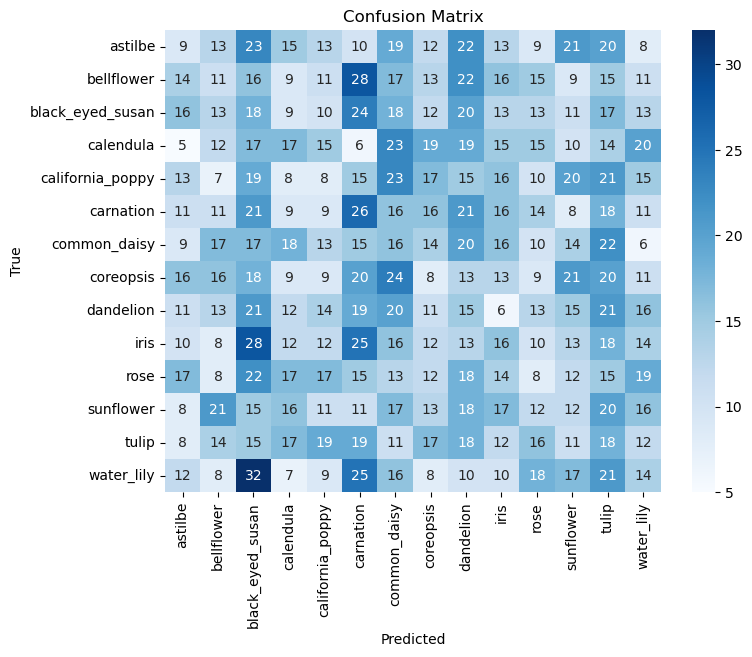

Our Confusion Matrix was all over the place. Clearly theres more we can do within our pre-processing. This is horrendous even for a baseline

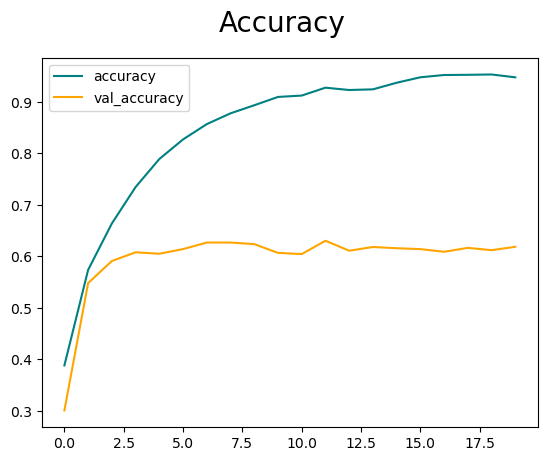

Our accuracy was sky-rocketing with the test scores plateauing, which is a telltale sign of overfitting. Thats why augmenting our data was able to improve the model significantly. It allows the model to generalize on the images and patterns more efficiently

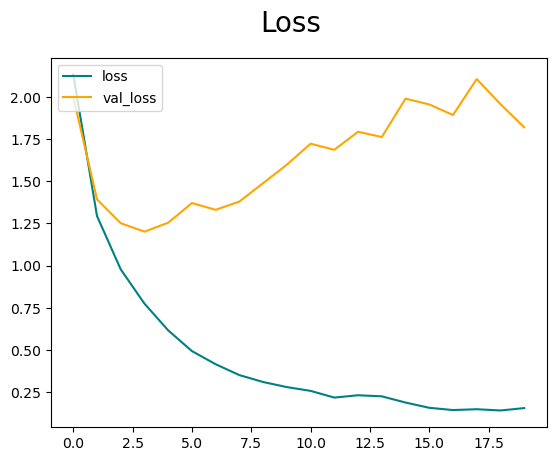

We see a similar trend within the loss. The val loss was actually getting worse the more it ran with the train loss getting better and better. Another sign of overfitting

## First CNN Model

### Dealing with Class Imbalance

My classes are slightly imbalanaced so I will be weighting them to account for this

In [9]:
# Number of samples in each class
class_samples = {
    'calendula': 811, 'bellflower': 672, 'iris': 841, 'astilbe': 526,
    'common_daisy': 778, 'california_poppy': 821, 'carnation': 724,
    'rose': 786, 'tulip': 834, 'black_eyed_susan': 786,
    'coreopsis': 835, 'dandelion': 838, 'water_lily': 777, 'sunflower': 813
}

# Create a mapping of class names to numerical indices
class_names = sorted(class_samples.keys())  # Sort class names alphabetically
class_indices = {name: index for index, name in enumerate(class_names)}

# Create an array of class indices corresponding to your samples
y = np.hstack([np.full(class_samples[class_name], class_indices[class_name]) for class_name in class_names])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(list(class_indices.values())), y=y)
class_weight_dict = {class_indices[class_name]: weight for class_name, weight in zip(class_names, class_weights)}


This is my model architecture

In [10]:
# Function to create a Keras model
def create_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(14, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Create a model instance
first_model = create_model()

In [12]:
# Define a TensorBoard callback to log training information
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

# Define a ModelCheckpoint callback to save the best model weights
checkpoint_callback = ModelCheckpoint(
    filepath='../code/models/first_model.h5',  # Specify the filename to save the best weights
    monitor='val_accuracy',       # Monitor validation accuracy
    save_best_only=True,      # Only save the best weights
    save_weights_only=True,   # Save only the model's weights, not the entire model
    verbose=1
)

# Train your model with the ModelCheckpoint and TensorBoard callbacks
first_history = first_model.fit(train_data, 
                    epochs=50, 
                    validation_data=test_data, 
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    class_weight=class_weight_dict
                   )



Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 2.3386 - accuracy: 0.3310
Epoch 1: val_accuracy improved from -inf to 0.13458, saving model to ../code/models\first_model.h5
170/170 [==============================] - 44s 237ms/step - loss: 2.3386 - accuracy: 0.3310 - val_loss: 2.8131 - val_accuracy: 0.1346
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 1.7663 - accuracy: 0.4370
Epoch 2: val_accuracy improved from 0.13458 to 0.25017, saving model to ../code/models\first_model.h5
170/170 [==============================] - 42s 250ms/step - loss: 1.7663 - accuracy: 0.4370 - val_loss: 2.1015 - val_accuracy: 0.2502
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 1.5518 - accuracy: 0.4854
Epoch 3: val_accuracy improved from 0.25017 to 0.52864, saving model to ../code/models\first_model.h5
170/170 [==============================] - 41s 239ms/step - loss: 1.5518 - accuracy: 0.4854 - val_loss: 1.3838 - val_accuracy: 0.5286
Epoch 4

In [13]:
# Load the best weights
first_model.load_weights('../code/models/first_model.h5')

# Evaluate the model on your test data and store the results
results = first_model.evaluate(test_data)

# Print the test loss and accuracy
test_loss, test_accuracy = results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

46/46 [==============================] - 4s 86ms/step - loss: 0.6985 - accuracy: 0.7667
Test Loss: 0.6984671354293823
Test Accuracy: 0.7667356729507446


From our intial scores of 59%, a 76.7% accuracy is a massive improvement. Our baseline model is already at a semi-acceptible accuracy. However I do believe we can improve it even more so with hyper parameter tuning. Our goal after tuning is +80%

lets analysis our loss, accuracy, and confusion matrices.

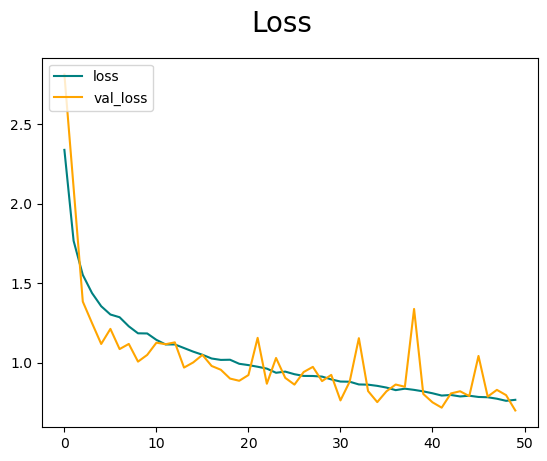

In [14]:
fig = plt.figure()
plt.plot(first_history.history['loss'], color='teal', label='loss')
plt.plot(first_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

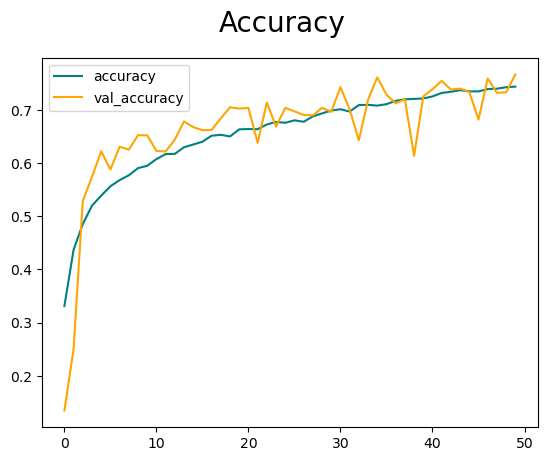

In [15]:
fig = plt.figure()
plt.plot(first_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(first_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

46/46 [==============================] - 4s 77ms/step


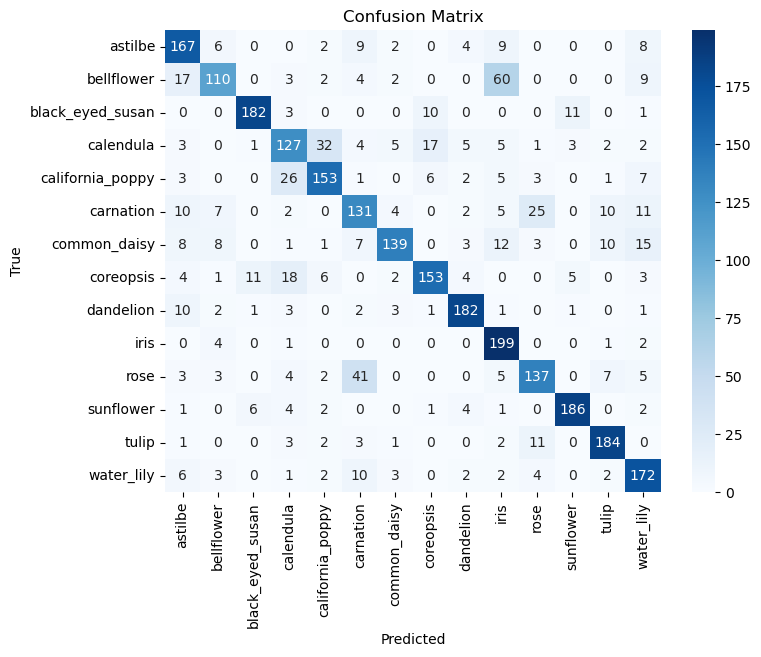

In [19]:
# Train model and get predicted probabilities
predicted_probabilities = first_model.predict(test_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get true labels from the test data generator
true_labels = test_data.classes

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Define class labels in the same order as the confusion matrix
class_labels = list(test_data.class_indices.keys())

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Our loss and accuracy graphs have improved significantly just by simply augmenting our data. The confusion matrix is also significantly cleaner and achieving the "diagnal" look that we were attemping to achieve. We should be able to advance this model even futher by hyperparameter tuning and adding regularizations to stop any overfitting as well as to find the best possible model. 

## Second CNN Model

### HyperParameter Tuning

In [38]:
class MyHyperband(Hyperband):

    def run_trial(self, trial, *args, **kwargs):
        # Ensure any existing callbacks are maintained
        if 'callbacks' in kwargs:
            callbacks = kwargs['callbacks']
        else:
            callbacks = []

        # Add custom callbacks with debugging information
        callbacks.extend([
            EarlyStopping(
                monitor='val_accuracy',
                patience=20,
                verbose=1,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                verbose=1,
                min_lr=1e-5
            ),
            TensorBoard(log_dir='./logs')
        ])

        # Debugging: Print the callbacks to be used
        print("Using callbacks:", [type(cb).__name__ for cb in callbacks])

        # Update the callbacks in kwargs
        kwargs['callbacks'] = callbacks

        # Call the superclass run_trial method
        return super(MyHyperband, self).run_trial(trial, *args, **kwargs)

The original hyperband did not include the regularization that I wanted to use so I created a class of my own to use it how I wanted to.

In [32]:
def build_hypermodel(hp: HyperParameters):
    model = Sequential()
    
    # Hyperparameters to tune
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.5, 0.7])
    hp_l1_rate = hp.Choice('l1_rate', values=[0.0, 0.001, 0.01])  # L1 regularization rates
    hp_l2_rate = hp.Choice('l2_rate', values=[0.0, 0.001, 0.01])  # L2 regularization rates

    # The same architecture as your baseline model with added L1/L2 regularization
    model.add(Conv2D(hp_units, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(hp_units * 2, (3, 3), activation='relu'))  # Using hp_units
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Conv2D(hp_units, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=hp_l1_rate, l2=hp_l2_rate)))
    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(14, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
# Define the custom tuner with EarlyStopping, ReduceLROnPlateau, and TensorBoard callbacks
tuner = MyHyperband(
    build_hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    seed=42,
    hyperband_iterations=5,
    directory='hyperband',
    project_name='keras_tuner_demo'
)

# Begin the hyperparameter tuning process
tuner.search(train_data, validation_data=test_data, epochs=50)

# After the search is completed, get the best model and hyperparameters
second_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Summarize the best model and hyperparameters
second_model.summary()

Trial 85 Complete [00h 24m 33s]
val_accuracy: 0.7515528202056885

Best val_accuracy So Far: 0.8098688721656799
Total elapsed time: 07h 52m 44s

Search: Running Trial #86

Value             |Best Value So Far |Hyperparameter
32                |64                |units
0.3               |0.5               |dropout_rate
0.001             |0                 |l1_rate
0                 |0.001             |l2_rate
50                |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
0                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Using callbacks: ['EarlyStopping', 'ReduceLROnPlateau', 'TensorBoard']
Epoch 1/50
170/170 [==============================] - 44s 257ms/step - loss: 15.2132 - accuracy: 0.3758 - val_loss: 7.9840 - val_accuracy: 0.0942 - lr: 0.0010
Epoch 2/50
170/170 [==============================] - 42s 249ms/step - loss: 5.0891 - accuracy: 0.4573 - val_loss: 5.9197 - val_accuracy: 0.2029 - 

KeyboardInterrupt: 

In [40]:
# Rebuild the best model using the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
second_model = build_hypermodel(best_hp)

# Compile the model
second_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='../code/models/second_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir='./logs')
]

# Train the model with the training data and validate using the validation data
second_history = second_model.fit(
    train_data,
    epochs=50,  # or any number of epochs you wish to train for
    validation_data=test_data,
    callbacks=callbacks,
    class_weight=class_weight_dict
    
)

Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 4.1387 - accuracy: 0.2654
Epoch 1: val_accuracy improved from -inf to 0.09731, saving model to ../code/models\second_model.h5
170/170 [==============================] - 69s 395ms/step - loss: 4.1387 - accuracy: 0.2654 - val_loss: 4.2914 - val_accuracy: 0.0973
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 2.9053 - accuracy: 0.3599
Epoch 2: val_accuracy improved from 0.09731 to 0.11836, saving model to ../code/models\second_model.h5
170/170 [==============================] - 53s 309ms/step - loss: 2.9053 - accuracy: 0.3599 - val_loss: 3.7223 - val_accuracy: 0.1184
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 2.4651 - accuracy: 0.4196
Epoch 3: val_accuracy improved from 0.11836 to 0.43064, saving model to ../code/models\second_model.h5
170/170 [==============================] - 50s 295ms/step - loss: 2.4651 - accuracy: 0.4196 - val_loss: 2.3539 - val_accuracy: 0.4306
Epoc

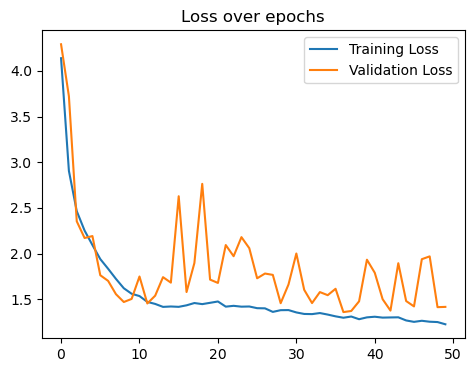

In [41]:
# Load the new weights 
second_model.load_weights('../code/models/second_model.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(second_history.history['loss'], label='Training Loss')
plt.plot(second_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

46/46 [==============================] - 4s 85ms/step - loss: 1.3601 - accuracy: 0.8206
Test Loss: 1.360099196434021
Test Accuracy: 0.8205658793449402


Text(0.5, 1.0, 'Accuracy over epochs')

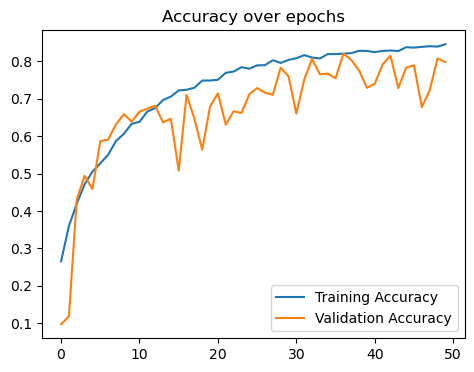

In [42]:
# Evaluate the trained model on the test data 
test_loss, test_accuracy = second_model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training history if needed
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(second_history.history['accuracy'], label='Training Accuracy')
plt.plot(second_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')


46/46 [==============================] - 4s 84ms/step


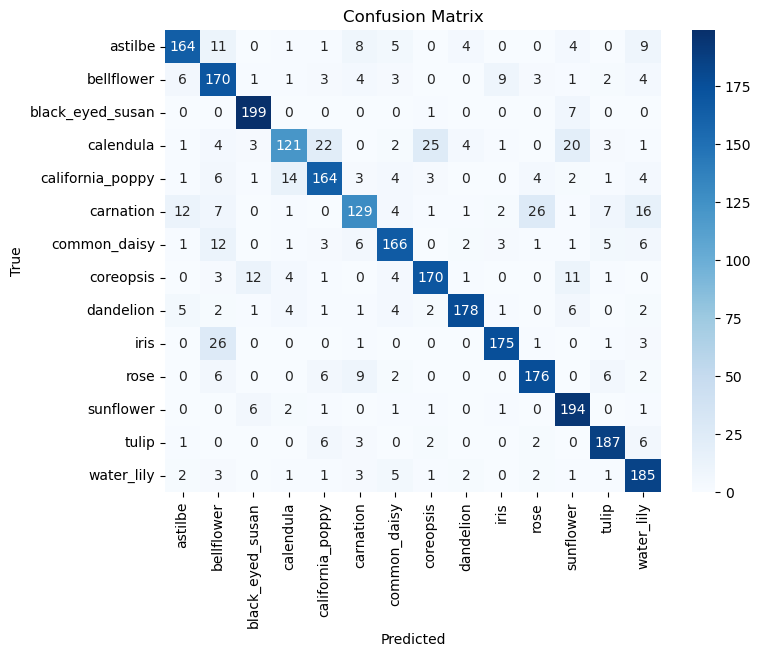

In [43]:
# Train model and get predicted probabilities
predicted_probabilities = second_model.predict(test_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get true labels from the test data generator
true_labels = test_data.classes

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Define class labels in the same order as the confusion matrix
class_labels = list(test_data.class_indices.keys())

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Transfer Learning - VGG16

### What is VGG16?

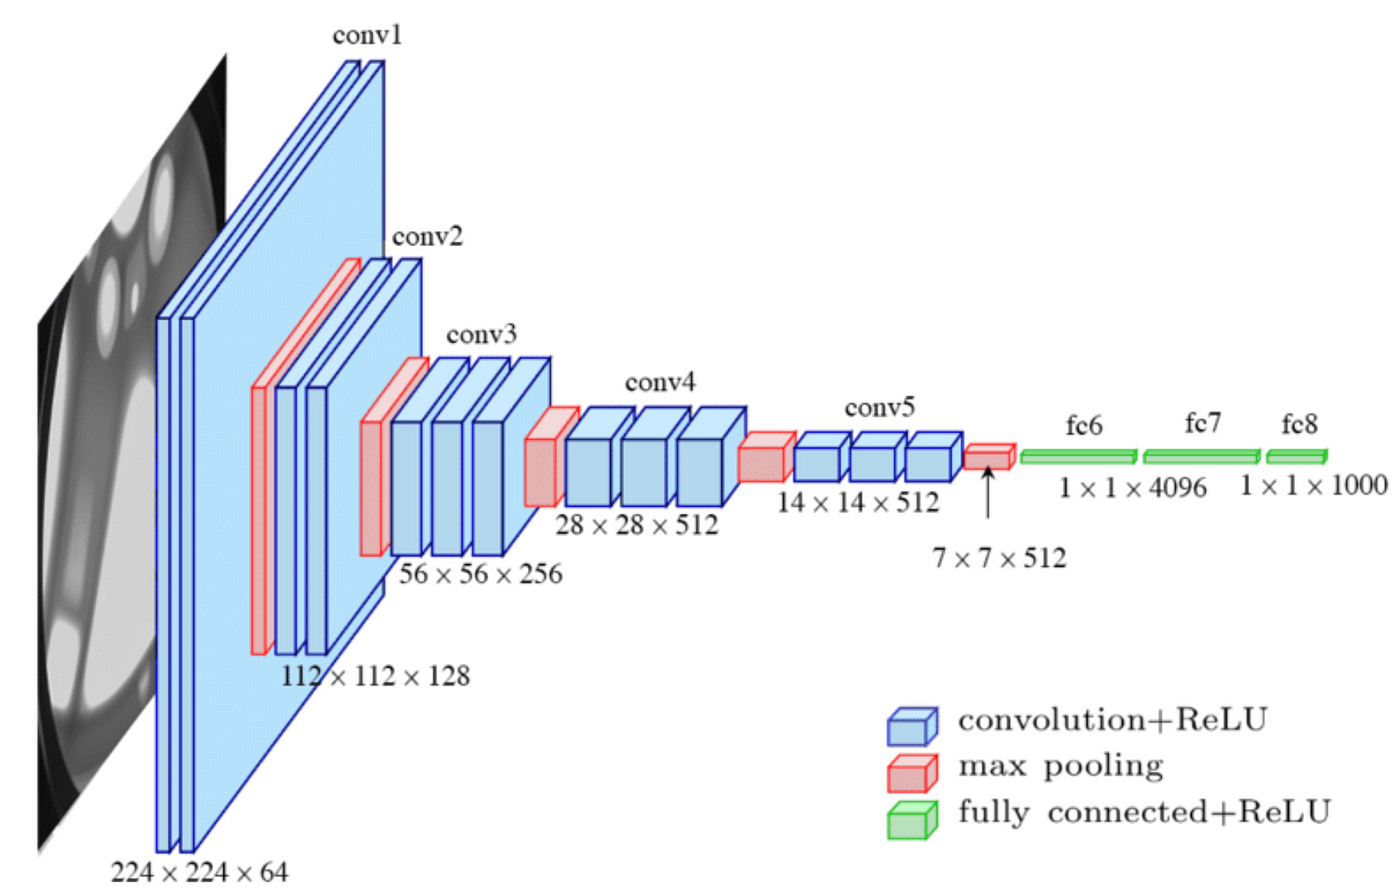

VGG16 is a convolutional neural network model known for its simplicity and depth. Developed by the Visual Graphics Group at Oxford (hence "VGG"), it was a breakthrough model in deep learning for image recognition tasks. The "16" refers to the number of layers with weights in the network. VGG16 is particularly noted for its use of 3x3 convolutional layers stacked on top of each other in increasing depth, which allows it to learn more complex features at each level. It achieved high accuracy in the ImageNet challenge, a prestigious competition in image classification and recognition. Due to its effectiveness and straightforward architecture, VGG16 is widely used as a starting point for image recognition and classification tasks, and as a benchmark for many computer vision problems.

In [50]:
from keras.applications.vgg16 import VGG16

def tune_vgg16(hp):
    model = Sequential()
    model.add(VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3)))
    model.add(Flatten())
    # Tuning the number of units in the first Dense layer
    # Choose an optimal value between 256-1024
    model.add(Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.3, step=0.05)))
    model.add(Dense(14, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

tuner = Hyperband(
    tune_vgg16,
    objective='val_accuracy',
    max_epochs=50,
    directory='hyperband',
    project_name='keras_tuner_vgg16'
)

tuner.search(train_data, epochs=50, validation_data=test_data)

Reloading Tuner from hyperband\keras_tuner_vgg16\tuner0.json


In [52]:
# Retrieving the best hyperparameters from the tuning process
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Loading and configuring the VGG16 base model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Constructing the model with the optimal hyperparameters
third_model = Sequential()
third_model.add(base_model)
third_model.add(Flatten())
third_model.add(Dense(best_hps.get('units'), activation='relu'))
third_model.add(Dropout(best_hps.get('dropout')))
third_model.add(Dense(14, activation='softmax'))  # Assuming 14 classes

# Compiling the model with the optimal learning rate
third_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Setting up a callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath='../code/models/third_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Training the model with the training and validation data
third_history = third_model.fit(train_data, 
                    epochs=50, 
                    validation_data=test_data, 
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    class_weight=class_weight_dict)

# Loading the weights of the best performing model
third_model.load_weights('../code/models/third_model.h5')


Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 1.1725 - accuracy: 0.6061
Epoch 1: val_accuracy improved from -inf to 0.77433, saving model to ../code/models\third_model.h5
170/170 [==============================] - 47s 272ms/step - loss: 1.1725 - accuracy: 0.6061 - val_loss: 0.6664 - val_accuracy: 0.7743
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8184
Epoch 2: val_accuracy improved from 0.77433 to 0.85576, saving model to ../code/models\third_model.h5
170/170 [==============================] - 46s 270ms/step - loss: 0.5591 - accuracy: 0.8184 - val_loss: 0.4625 - val_accuracy: 0.8558
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8655
Epoch 3: val_accuracy improved from 0.85576 to 0.87923, saving model to ../code/models\third_model.h5
170/170 [==============================] - 48s 281ms/step - loss: 0.4188 - accuracy: 0.8655 - val_loss: 0.3987 - val_accuracy: 0.8792
Epoch 4

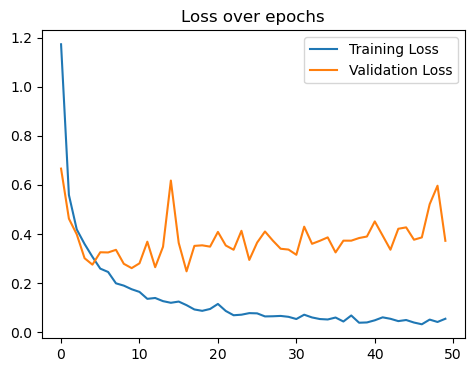

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(third_history.history['loss'], label='Training Loss')
plt.plot(third_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

46/46 [==============================] - 4s 76ms/step - loss: 0.2946 - accuracy: 0.9317
Test Loss: 0.29460540413856506
Test Accuracy: 0.9316770434379578


Text(0.5, 1.0, 'Accuracy over epochs')

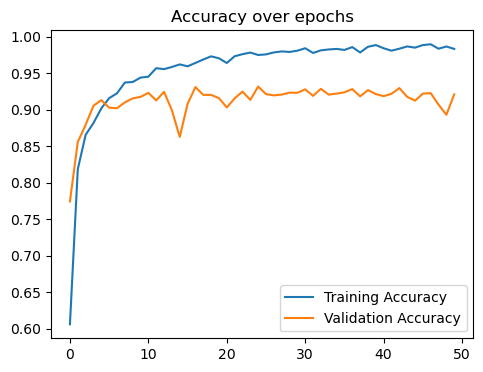

In [54]:
# Evaluate the trained model on the test data 
test_loss, test_accuracy = third_model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training history if needed
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(third_history.history['accuracy'], label='Training Accuracy')
plt.plot(third_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')


46/46 [==============================] - 4s 76ms/step


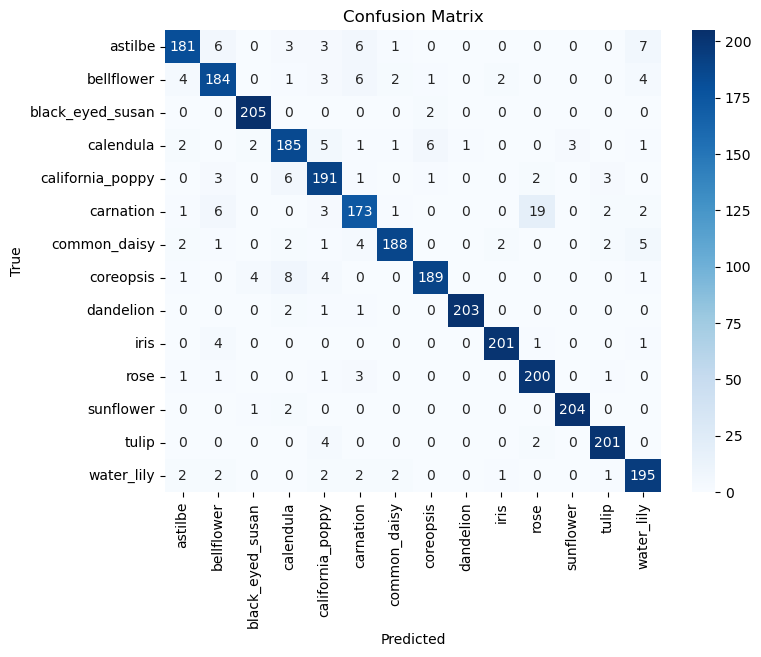

In [55]:
# Train model and get predicted probabilities
predicted_probabilities = third_model.predict(test_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get true labels from the test data generator
true_labels = test_data.classes

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Define class labels in the same order as the confusion matrix
class_labels = list(test_data.class_indices.keys())

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Recommendations


 * Enhanced Product Offerings for BlossomShop: Integrate the flower recognition technology into BlossomShop's mobile app. This feature will enable users to snap a picture of any flower and receive immediate information, including care instructions, availability on BlossomShop, and purchasing options. This not only improves customer engagement but also potentially increases sales.
<br>

 * Gardening App Integration: Implement the model into BlossomGarden’s apps, providing gardeners with instant flower identification and care tips. This feature can enhance user experience and potentially attract new customers to BlossomTech’s gardening solutions.
<br>

 * Customized Marketing Strategies: Analyze the user interaction data with the flower recognition feature to understand customer preferences and behaviors. This information can be used to tailor marketing campaigns, recommend products, and create more personalized shopping experiences on BlossomShop.
<br>

 * Licensing the Technology: Consider licensing your model to other companies in related fields, such as florists, landscaping firms, and botanical gardens. This can be an additional revenue stream for BlossomTech.

# Next Steps

All though a 34% increase in accuracy is fantasistic There is more we can do to improve the accuracy even further

1. Architecture Modifications:

    * Increase Model Complexity: Experiment with adding more convolutional layers, increasing the number of filters, or using deeper neural network architectures. Be cautious not to overfit, and use dropout layers to regularize if needed.
    <br>
    
    * Adjust Pooling Layers: Try different pooling techniques like AveragePooling2D or GlobalAveragePooling2D instead of MaxPooling2D to capture different features.
    <br>
    

2. Ensemble Learning:

    * Combine Multiple Models: Train multiple models with different architectures or hyperparameters and ensemble their predictions. This can help improve overall accuracy.
<br>

3. Custom Loss Functions:

    * Design custom loss functions that emphasize specific aspects of your task, such as reducing false positives or false negatives, if your dataset has imbalanced classes.